<a href="https://colab.research.google.com/github/gilgarad/mldl4automation/blob/master/code_tests/AutoEncoderTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 참조: https://keraskorea.github.io/posts/2018-10-23-keras_autoencoder/
# This is mostly copied from someone else, the purpose is to understand and test (could be changed a bit)

# Import Libraries

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import LSTM, RepeatVector
from keras.models import Model

from keras import regularizers
from keras.callbacks import TensorBoard
import keras.backend.tensorflow_backend as K

import numpy as np

# Matplotlib 사용
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Download Data and set default variables

In [2]:
LOG_DIR = 'drive/data/tb_logs' # Save in google drive path
# LOG_DIR = '/content/gdrive/data/tb_logs' # Save in google drive path
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

import os
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

get_ipython().system_raw(
  'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
  .format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-04-09 00:46:30--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.204.136.9, 34.206.253.53, 52.86.186.182, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.204.136.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  36.7MB/s    in 0.4s    

2019-04-09 00:46:31 (36.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://0927783a.ngrok.io


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Original x_train.shape:', x_train.shape)
print('Original x_train.shape:', x_test.shape)
      
# Make all data to be between 0 to 1 
x_train_flat = x_train / 255
x_train_flat = x_train_flat.reshape(x_train_flat.shape[0], np.prod(x_train_flat.shape[1:]))
x_test_flat = x_test / 255
x_test_flat = x_test_flat.reshape(x_test_flat.shape[0], np.prod(x_test_flat.shape[1:]))

print('Changed Shape (Flattened shape and normalize data as between 0 to 1)')
print('Flattened x_train_flat.shape:', x_train_flat.shape)
print('Flattened x_test_flat.shape:', x_test_flat.shape)

11493376/11490434 [==============================] - 0s 0us/step
Original x_train.shape: (60000, 28, 28)
Original x_train.shape: (10000, 28, 28)
Changed Shape (Flattened shape and normalize data as between 0 to 1)
Flattened x_train_flat.shape: (60000, 784)
Flattened x_test_flat.shape: (10000, 784)


# Tester Class for train and test

In [0]:
class AutoEncoderTester:
    def __init__(self, model):
        
        self.model = model
       
    def train(self, x_train, y_train, x_test, y_test, epochs=50, batch_size=256, 
              verbose=1):
        
        self.model.autoencoder.fit(x_train, y_train, 
                                   validation_data=(x_test, y_test), 
                                   epochs=epochs, batch_size=batch_size, 
                                   shuffle=True, 
                                   verbose=verbose,
                                  callbacks=[
                                      TensorBoard(log_dir=LOG_DIR, 
                                                  histogram_freq=0,
                                                  write_graph=True,
                                                  write_grads=True,
#                                                   batch_size=batch_size,
#                                                   write_images=True
                                                 )
                                  ])
        
    def test(self, x_test):
        encoded_imgs = self.model.encoder.predict(x_test)
        decoded_imgs = self.model.decoder.predict(encoded_imgs)
        
        n = 10  # 몇 개의 숫자를 나타낼 것인지
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # 원본 데이터
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(x_test[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # 재구성된 데이터
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

# Models

In [0]:
class BaseModel:
    def __init__(self):
        encode_dim = 32

        inputs = Input(shape=(784, ))
        encoded = Dense(encode_dim, activation='relu')(inputs)
        decoded = Dense(784, activation='sigmoid')(encoded)

        autoencoder = Model(inputs=inputs, outputs=decoded)


        encoder = Model(inputs=inputs, outputs=encoded)

        encoded_inputs = Input(shape=(encode_dim, ))
        decoder_layer = autoencoder.layers[-1]
        decoder = Model(inputs=encoded_inputs, outputs=decoder_layer(encoded_inputs))


        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        
        self.encoder = encoder
        self.decoder = decoder
        self.autoencoder = autoencoder

60000/60000 [==============================] - 4s 65us/step - loss: 0.1144 - val_loss: 0.1126
Epoch 133/200
60000/60000 [==============================] - 4s 66us/step - loss: 0.1142 - val_loss: 0.1124
Epoch 134/200
60000/60000 [==============================] - 4s 66us/step - loss: 0.1139 - val_loss: 0.1121
Epoch 135/200
60000/60000 [==============================] - 4s 66us/step - loss: 0.1137 - val_loss: 0.1119
Epoch 136/200
60000/60000 [==============================] - 4s 66us/step - loss: 0.1134 - val_loss: 0.1116
Epoch 137/200
60000/60000 [==============================] - 4s 67us/step - loss: 0.1132 - val_loss: 0.1114
Epoch 138/200
60000/60000 [==============================] - 4s 67us/step - loss: 0.1130 - val_loss: 0.1112
Epoch 139/200
60000/60000 [==============================] - 4s 65us/step - loss: 0.1127 - val_loss: 0.1109
Epoch 140/200
60000/60000 [==============================] - 4s 65us/step - loss: 0.1125 - val_loss: 0.1107
Epoch 141/200
60000/60000 [===============

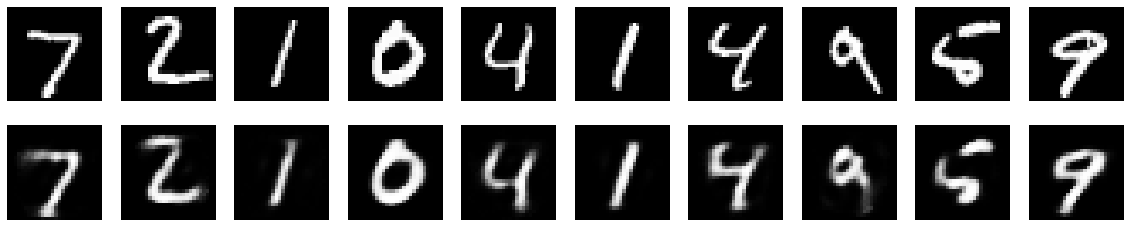

In [0]:
base_model = AutoEncoderTester(model=BaseModel())
base_model.train(x_train=x_train_flat, y_train=x_train_flat, x_test=x_test_flat, y_test=x_test_flat,
                epochs=200, batch_size=1024, verbose=1)
base_model.test(x_test=x_test_flat)


In [0]:
class RegularizedModel:
    def __init__(self):
        encoding_dim = 32

        inputs = Input(shape=(784,))
        # L1 activity regularizer를 Dense layer에 추가 
        encoded = Dense(encoding_dim, activation='relu',
                        activity_regularizer=regularizers.l1(10e-5))(inputs)
        decoded = Dense(784, activation='sigmoid')(encoded)

        autoencoder = Model(inputs, decoded)
        
        encoder = Model(inputs=inputs, outputs=encoded)

        encoded_inputs = Input(shape=(encode_dim, ))
        decoder_layer = autoencoder.layers[-1]
        decoder = Model(inputs=encoded_inputs, outputs=decoder_layer(encoded_inputs))


        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        
        self.encoder = encoder
        self.decoder = decoder
        self.autoencoder = autoencoder

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 78us/step - loss: 0.7095 - val_loss: 0.6826
Epoch 2/200
60000/60000 [==============================] - 4s 69us/step - loss: 0.6765 - val_loss: 0.6704
Epoch 3/200
60000/60000 [==============================] - 4s 70us/step - loss: 0.6648 - val_loss: 0.6591
Epoch 4/200
60000/60000 [==============================] - 4s 70us/step - loss: 0.6538 - val_loss: 0.6483
Epoch 5/200
60000/60000 [==============================] - 4s 70us/step - loss: 0.6431 - val_loss: 0.6378
Epoch 6/200
60000/60000 [==============================] - 4s 72us/step - loss: 0.6328 - val_loss: 0.6277
Epoch 7/200
60000/60000 [==============================] - 4s 71us/step - loss: 0.6229 - val_loss: 0.6180
Epoch 8/200
60000/60000 [==============================] - 4s 71us/step - loss: 0.6134 - val_loss: 0.6087
Epoch 9/200
60000/60000 [==============================] - 4s 71us/step - loss: 0.6042 - val_loss: 0.5

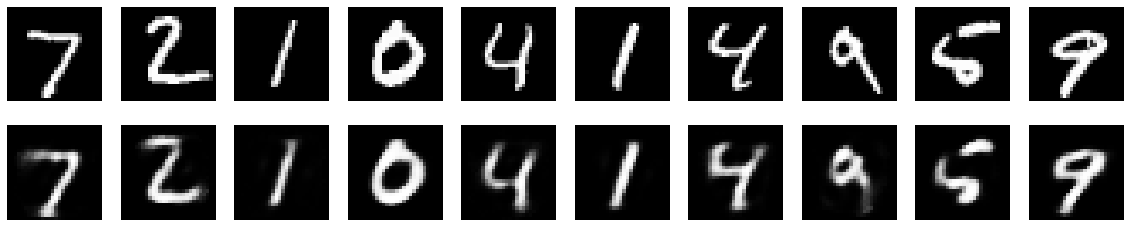

In [0]:
regularized_model = AutoEncoderTester(RegularizedModel())
regularized_model.train(x_train=x_train_flat, y_train=x_train_flat, x_test=x_test_flat, y_test=x_test_flat,
                epochs=200, batch_size=1024, verbose=1)
regularized_model.test(x_test=x_test_flat)

In [0]:
class DeepModel:
    def __init__(self):
        encode_dim = 32

        inputs = Input(shape=(784,))
        encoded = Dense(128, activation='relu')(inputs)
        encoded = Dense(64, activation='relu')(encoded)
        encoded = Dense(32, activation='relu')(encoded)

        decoded = Dense(64, activation='relu')(encoded)
        decoded = Dense(128, activation='relu')(decoded)
        decoded = Dense(784, activation='sigmoid')(decoded)

        autoencoder = Model(inputs, decoded)
        
        encoder = Model(inputs=inputs, outputs=encoded)

        encoded_inputs = Input(shape=(encode_dim, ))
#         decoder_layer = autoencoder.layers[-3:]
        decoder_layer = encoded_inputs
        for layer in autoencoder.layers[-3:]:
            decoder_layer = layer(decoder_layer)
        decoder = Model(inputs=encoded_inputs, outputs=decoder_layer)


        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        
        self.encoder = encoder
        self.decoder = decoder
        self.autoencoder = autoencoder

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 2s 26us/step - loss: 0.5071 - val_loss: 0.2734
Epoch 2/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2699 - val_loss: 0.2668
Epoch 3/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2659 - val_loss: 0.2649
Epoch 4/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2637 - val_loss: 0.2622
Epoch 5/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2610 - val_loss: 0.2597
Epoch 6/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2581 - val_loss: 0.2570
Epoch 7/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2545 - val_loss: 0.2518
Epoch 8/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2501 - val_loss: 0.2472
Epoch 9/200
60000/60000 [==============================] - 1s 19us/step - loss: 0.2459 - val_loss: 0.2

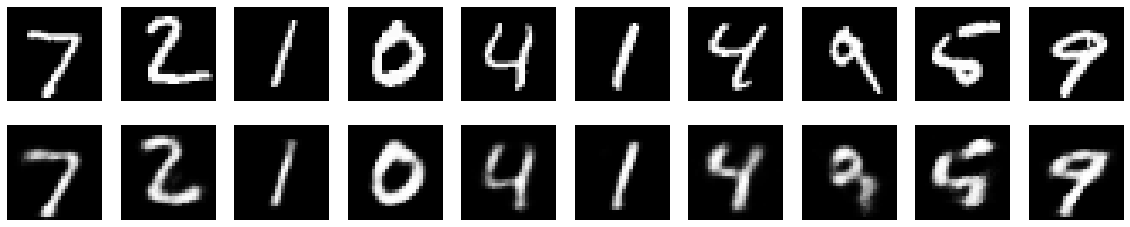

In [0]:
deep_model = AutoEncoderTester(DeepModel())
deep_model.train(x_train=x_train_flat, y_train=x_train_flat, x_test=x_test_flat, y_test=x_test_flat,
                epochs=200, batch_size=1024, verbose=1)
deep_model.test(x_test=x_test_flat)

In [0]:
class ConvModel:
    def __init__(self):

        inputs = Input(shape=(28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용

        x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # 이 시점에서 표현(representatoin)은 (4,4,8) 즉, 128 차원

        x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(16, (3, 3), activation='relu')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(inputs, decoded)
        
        encoder = Model(inputs=inputs, outputs=encoded)

        # Decoder for Predict
        encoded_inputs = Input(shape=(4, 4, 8))
#         decoder_layer = autoencoder.layers[-3:]
        decoder_layer = encoded_inputs
        for layer in autoencoder.layers[-7:]:
            decoder_layer = layer(decoder_layer)
        decoder = Model(inputs=encoded_inputs, outputs=decoder_layer)


        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        
        self.encoder = encoder
        self.decoder = decoder
        self.autoencoder = autoencoder

https://3f75f667.ngrok.io
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 86us/step - loss: 0.3748 - val_loss: 0.2391
Epoch 2/200
60000/60000 [==============================] - 3s 57us/step - loss: 0.2247 - val_loss: 0.2164
Epoch 3/200
60000/60000 [==============================] - 3s 54us/step - loss: 0.2061 - val_loss: 0.1971
Epoch 4/200
60000/60000 [==============================] - 3s 54us/step - loss: 0.1935 - val_loss: 0.1913
Epoch 5/200
60000/60000 [==============================] - 3s 52us/step - loss: 0.1851 - val_loss: 0.1814
Epoch 6/200
60000/60000 [==============================] - 3s 57us/step - loss: 0.1776 - val_loss: 0.1769
Epoch 7/200
60000/60000 [==============================] - 3s 53us/step - loss: 0.1718 - val_loss: 0.1697
Epoch 8/200
60000/60000 [==============================] - 3s 

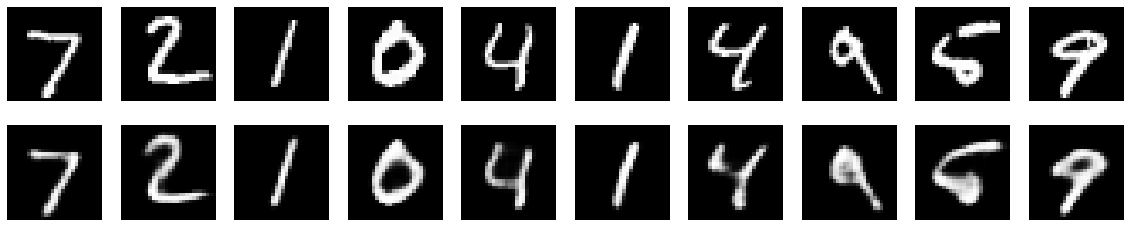

In [8]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Reshape for conv2d
x_train_3d = np.reshape(x_train_flat, (len(x_train_flat), 28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용
x_test_3d = np.reshape(x_test_flat, (len(x_test_flat), 28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용

conv_model = AutoEncoderTester(ConvModel())
conv_model.train(x_train=x_train_3d, y_train=x_train_3d, x_test=x_test_3d, y_test=x_test_3d,
                epochs=200, batch_size=1024, verbose=1)
conv_model.test(x_test=x_test_3d)

In [0]:
# Same as ConvModel, but number of filter increased
class DenoiseConvModel:
    def __init__(self):
        
        num_filters = 64
        
        inputs = Input(shape=(28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용

        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(inputs)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # 이 시점에서 표현(representatoin)은 (4,4,8) 즉, 128 차원

        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(num_filters, (3, 3), activation='relu')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(inputs, decoded)
        
        encoder = Model(inputs=inputs, outputs=encoded)

        # Decoder for Predict
        encoded_inputs = Input(shape=(4, 4, num_filters))
#         decoder_layer = autoencoder.layers[-3:]
        decoder_layer = encoded_inputs
        for layer in autoencoder.layers[-7:]:
            decoder_layer = layer(decoder_layer)
        decoder = Model(inputs=encoded_inputs, outputs=decoder_layer)


        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        
        self.encoder = encoder
        self.decoder = decoder
        self.autoencoder = autoencoder
        
        print(autoencoder.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_

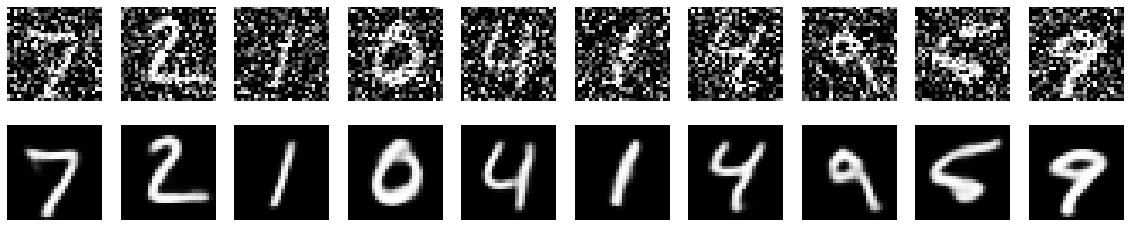

In [7]:
# Reshape for conv2d
x_train_3d = np.reshape(x_train_flat, (len(x_train_flat), 28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용
x_test_3d = np.reshape(x_test_flat, (len(x_test_flat), 28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용

noise_factor = 0.5
x_train_3d_noisy = x_train_3d + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_3d.shape) 
x_test_3d_noisy = x_test_3d + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_3d.shape) 

x_train_3d_noisy = np.clip(x_train_3d_noisy, 0., 1.)
x_test_3d_noisy = np.clip(x_test_3d_noisy, 0., 1.)


dconv_model = AutoEncoderTester(DenoiseConvModel())
dconv_model.train(x_train=x_train_3d_noisy, y_train=x_train_3d, 
                 x_test=x_test_3d_noisy, y_test=x_test_3d,
                epochs=200, batch_size=1024, verbose=1)
dconv_model.test(x_test=x_test_3d_noisy)

In [0]:
# Same as ConvModel, but number of filter increased
class Seq2SeqModel:
    def __init__(self):
        
        timesteps = 28
        input_dim = 28
        latent_dim = 128
        
        inputs = Input(shape=(timesteps, input_dim))
        encoded = LSTM(latent_dim)(inputs)

        decoded = RepeatVector(timesteps)(encoded)
        decoded = LSTM(input_dim, return_sequences=True)(decoded)

        autoencoder = Model(inputs, decoded)
        
        encoder = Model(inputs=inputs, outputs=encoded)

        # Decoder for Predict
        encoded_inputs = Input(shape=(timesteps, input_dim))
#         decoder_layer = autoencoder.layers[-3:]
        decoder_layer = encoded_inputs
        for layer in autoencoder.layers[-2:]:
            decoder_layer = layer(decoder_layer)
        decoder = Model(inputs=encoded_inputs, outputs=decoder_layer)


        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        
        self.encoder = encoder
        self.decoder = decoder
        self.autoencoder = autoencoder
        
        print(autoencoder.summary())

In [46]:
x_test.shape

(10000, 28, 28)

In [47]:
seq2seq_model = AutoEncoderTester(Seq2SeqModel())
seq2seq_model.train(x_train=x_train, y_train=x_train, 
                 x_test=x_test, y_test=x_test,
                epochs=200, batch_size=1024, verbose=1)
seq2seq_model.test(x_test=x_test)

ValueError: ignored